In [5]:
import numpy as np
import matplotlib.pyplot as plt
import copy
np.set_printoptions(precision=2)
from pathlib import Path

import wave as w
import constants as c
import material as m
import style

# Example usage of simulated materials
This notebook is ment as an reference on how to use `PlaneWave` and `Material` classes,
and for visual test of the implementation.

In [6]:
figures_dir = "figures/"
Path(figures_dir).mkdir(parents=True, exist_ok=True)

### Generate an example spectrum
Just an example how to create and plot wave.

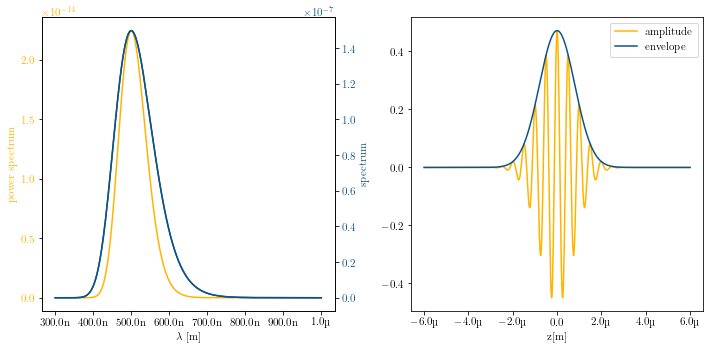

In [7]:
s = w.GaussianPlanarWave(mean=c.GREEN, std=(5*c.MICRO))
s_replay = w.WhitePlanarWave()
z = np.linspace(-6*c.MICRO, 6*c.MICRO, 1000)
s.delay(0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
s.plot(ax=ax1, spectrum_axis=ax1.twinx(), wavelength=True)
s.plot_amplitude(z, ax=ax2)
ax2.legend()
fig.tight_layout()
plt.savefig(figures_dir + "spectrum.pdf", transparent=True)
plt.show()

### Compare different materials

#### Analitical vs constant vs matrix theory
Create the same material (empty space) using three different material models in oder to inspect that they give the same resut.

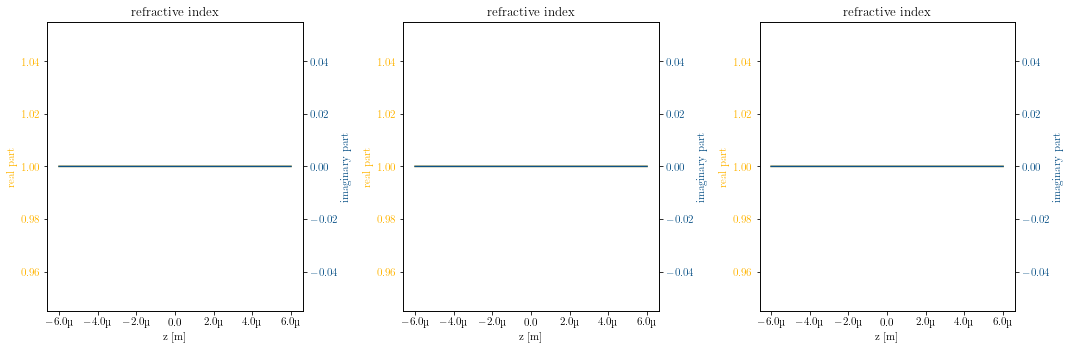

In [8]:
air = m.EmptySpace(z=z, name="analytic")
common_n = 1
fixed_dielectric = m.ConstantMaterial(z=z, n0=common_n, name="phase shift")
dielectric = m.SimpleDielectric(z=z, n0=1, name="transfer matrices")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

air.plot(ax1, imaginary_axis=ax1.twinx())
fixed_dielectric.plot(ax2, imaginary_axis=ax2.twinx())
dielectric.plot(ax3, imaginary_axis=ax3.twinx())
fig.tight_layout() 
plt.show()

Calculate interference pattern in those three materials: again we can see that the patterns match. 
The index of refraction after recording would be different in those materials because ConstantMaterial's index of refraction cannot be modified.

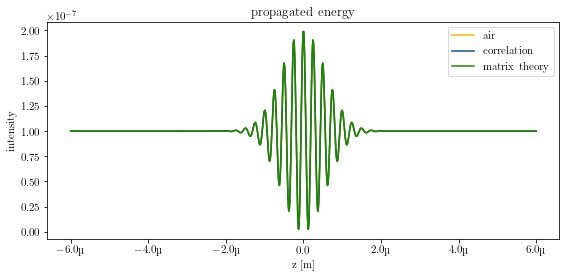

In [9]:
fig, (ax1) = plt.subplots(1, 1, figsize=(8,4))

air.record(s,s)
air.plot_recent_energy(ax1, label="air")
fixed_dielectric.record(s,s)
fixed_dielectric.plot_recent_energy(ax1, label="correlation")
dielectric.record(s,s)
dielectric.plot_recent_energy(ax1, label="matrix theory")
ax1.legend()
plt.show()

### An example recording

Left: interference pattern 
created in the material. Middle: index of 
refraction after recording. Right: reflected pulse, when the 
incoming pulse was the same as the recorded.

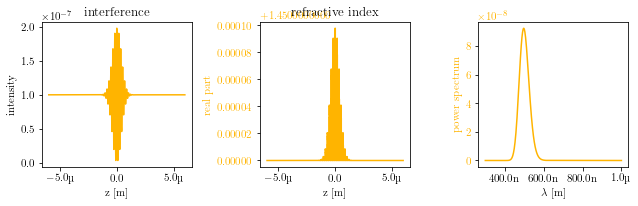

In [10]:
z = np.linspace(-6*c.MICRO, 6*c.MICRO, 1000)
dielectric = m.SimpleDielectric(z=z, n0=1.45, name="transfer matrices")
s0 = w.GaussianPlanarWave(mean=c.GREEN, std=(5*c.MICRO))
dielectric.record(s0, s0)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
dielectric.plot_recent_energy(ax1)
ax1.set_title("interference")
dielectric.plot(ax=ax2)
dielectric.reflect(s_replay).plot(ax3, wavelength=True)
plt.tight_layout()
plt.savefig(figures_dir + "recording.pdf", transparent=True)
plt.show()

### Layered material

Left: interference 
pattern 
created in the material. Middle: index of refraction after recording. Right: 
reflected pulse. All inner implementations are the same as for dielectric.
Additionally, on the first two plots shading is 
added to indicate layers of different index of 
refraction.

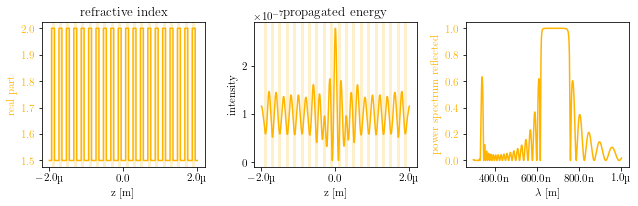

In [11]:
z_layered = np.linspace(-2*c.MICRO, 2*c.MICRO, 2000)
layered = m.LayeredMaterial(z=z_layered, n_layers=20, layer_width=80*c.NANO, n0=1.5, n1=2.0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
layered.shade_plot(ax1, alpha=0.2)
layered.plot(ax1)
layered.shade_plot(ax2, alpha=0.2)
layered.reflect(s_replay).plot(ax3, label="reflected", wavelength=True)
layered.record(s, s)
layered.plot_recent_energy(ax2)
fig.tight_layout() 
plt.savefig(figures_dir + "layered.pdf",transparent=True)
plt.show()

### Composite Material

Left: 
interference pattern 
created in the material. Middle: index of refraction after recording. Right: 
reflected pulse. All inner implementations are the same as for dielectric. Again, the shading is 
added to indicate different components. The strange reflected wave shape comes mostly from interfaces with air which haven't been modeled before.

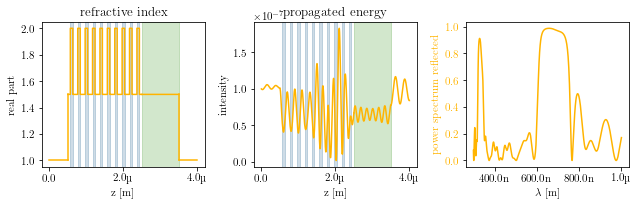

In [12]:
z_layered = np.linspace(-1*c.MICRO, 1*c.MICRO, 2000)
z_air = np.linspace(-0.5*c.MICRO, 0, 500)
z_clean = np.linspace(-1*c.MICRO, 0, 1000)
air = m.EmptySpace(z=z_air)
air2 = m.EmptySpace(z=np.copy(z_air))
clean = m.SimpleDielectric(z=z_clean, n0=1.5)
layered = m.LayeredMaterial(z=z_layered, n_layers=10, layer_width=100*c.NANO/1.5, n0=1.5, n1=2.0)
composite = m.CompositeMaterial([air, layered, clean, air2])


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
composite.shade_plot(ax1, alpha=0.2)
composite.plot(ax1, color="C0")
composite.shade_plot(ax2, alpha=0.2)
composite.reflect(s_replay).plot(ax3, label="reflected", wavelength=True)
composite.record(s, s)
composite.plot_recent_energy(ax2, color="C0")
fig.tight_layout() 
plt.savefig(figures_dir + "composite.pdf",transparent=True)
plt.show()

### Random phase example

Random phase. One pulse is kept the same, and the phase of the second 
one is choose uniformly at random form interval $(0, \pi)$. On the top left 
plot we can see that the interference patter indeed get blurred, and on the top 
right we can see that there is indeed a Gaussian shape emerging at the basis of 
the interference pattern. Fortunately, the patter still has a lot of variance at 
the right frequency, and thus with each pulse more gets reflected, as depicted 
at the bottom plots. We can see that there gain is not the same with every 
pulse.

AttributeError: module 'style' has no attribute 'colors'

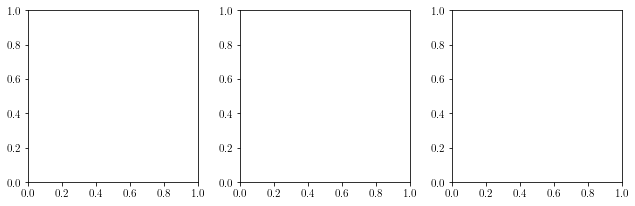

In [18]:
import time

dielectric = m.SimpleDielectric(z=z, n0=1)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
pulse = s0

start = time.time()
for pulse, color in enumerate(style.colors):
    phase = np.random.uniform(0, np.pi)
    s2 = s0 * np.exp(1j*phase)
    dielectric.plot(ax=ax2, color=color, change_only=True)
    dielectric.record(s0, s2)
    dielectric.plot_recent_energy(ax1, label="pulse {}".format(pulse + 1), c=color)
    dielectric.reflect(s_replay).plot(ax3, color=color)

ax1.set_title("interference")
ax3.set_title("reflected")
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

print("{} recordings took {}s".format(steps, time.time()-start))
ax3.legend([f"p. {nr + 1}" for nr in range(steps)])

plt.tight_layout()
plt.savefig(figures_dir + "random_phase.pdf")
plt.show()

### Sweeping phase example

Random phase. One pulse is kept the same, and the phase of the second 
one is changing by $\pi/20$ with each pulse. On the top left 
plot we can see that the interference patter shifts to the right, and on the top 
right we can see the refractive index pattern is much sharper than in the previous example. The total reflection is however very similar. It seems 
to reach saturation faster, and be slightly sharper in wavelength.

In [ ]:
dielectric = m.SimpleDielectric(z=z, n0=1)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

for pulse, color in enumerate(style.colors):
    phase = 0.5*np.pi*pulse/steps
    s2 = s0 * np.exp(1j*phase)
    dielectric.plot(ax=ax2, color=color, change_only=True)
    dielectric.record(s0, s2)
    dielectric.plot_recent_energy(ax1, label="pulse {}".format(pulse + 1), c=color)
    dielectric.reflect(s_replay).plot(ax3, color=color)
    
ax1.set_title("interference")
ax3.set_title("reflected")
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax3.legend([f"p. {nr + 1}" for nr in range(steps)])

plt.tight_layout()
plt.savefig(figures_dir + "sweeping_phase.pdf")      
plt.show()

In [ ]:
import time

dielectric = m.SimpleDielectric(z=z, n0=1)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
pulse = s0
interference = dielectric.deposited_energy

start = time.time()
for pulse, color in enumerate(style.colors):
    phase = np.random.uniform(0, 2*np.pi)
    s2 = s0 * np.exp(1j*phase)
    dielectric.plot(ax=ax2, color=color, change_only=True)
    dummy_dielectric =  m.SimpleDielectric(z=z, n0=1)
    dummy_dielectric.record(s0, s2)
    dielectric.deposited_energy += dielectric.energy_response(dummy_dielectric.recent_energy)
    dummy_dielectric.plot_recent_energy(ax1, label="pulse {}".format(pulse + 1), c=color)
    dielectric.reflect(s_replay).plot(ax3, color=color)
    
print("{} recordings took {}s".format(steps, time.time()-start))

ax1.set_title("interference")
ax3.set_title("reflected")
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax3.legend([f"p. {nr + 1}" for nr in range(steps)])

plt.tight_layout()
plt.savefig(figures_dir + "random_phase_worst_case.pdf")
plt.show()

### Self organisation example
**Warning: this example is not realistic.** It is a proof of concept that with small inintial modification (made by interference) much bigger modification can be build with *just one* pulse of the right frequency. The parameters are choosen for this simulation to give desired resutls and are not realistic.

In [ ]:
dielectric = m.SimpleDielectric(z=z, n0=0.5)
dielectric.max_dn = 0.5
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
pulse = s0

start = time.time()
for pulse, color in enumerate(style.colors):
    phase = np.random.uniform(0, np.pi)
    if pulse > 0:
        s2 = s0 * 0
        s1 = 1.4 * s0
    else:
        s2 = 0.8 * s0
        s1 = 0.8 * s0
    dielectric.record(s1, s2)
    dielectric.plot(ax=ax2, color=color, change_only=True)
    if pulse > 0:
        dielectric.plot_recent_energy(ax1, c=color)
    dielectric.reflect(s_replay).plot(ax3, color=color)
    
ax1.set_title("interference")
ax3.set_title("reflected")
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax3.legend([f"p. {nr + 1}" for nr in range(steps)])
    
plt.tight_layout()
plt.savefig(figures_dir + "self_organisation.pdf")
plt.show()

### Chirps example

#### Different chirps interfering with their copies. 
Left: chirping Gaussian spectrum leads to spreading of the pulse amplitude in 
time (and thus in space). Middle and right: the recorded patterns and reflected 
spectra look the same across the experiments.

In [ ]:
z = np.linspace(-6*c.MICRO, 6*c.MICRO, 2000)
probing_wave = w.GaussianPlanarWave(mean=c.GREEN, std=(5*c.MICRO))
for chirp in np.linspace(0, 0.002*c.NANO, 3):
    dielectric = m.SimpleDielectric(z=z, n0=1.45, name="transfer matrices")
    chirped_wave = w.ChirpedPlanarWave(mean=c.GREEN, std=(5*c.MICRO), skew=chirp)
    chirped_wave.shift(chirp*2000)
    dielectric.record(chirped_wave, chirped_wave)
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(12, 3))
    chirped_wave.plot_amplitude(z, ax=ax1)
    chirped_wave.plot_amplitude(z, ax=ax0)
    ax1.set_title("no-chirp" if chirp == 0 else "chirp")
    ax0.set_title("no-chirp" if chirp == 0 else "chirp")
    dielectric.plot(ax=ax2, change_only=True)
    dielectric.reflect(s_replay).plot(ax3)
    ax2.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
    plt.tight_layout()
    plt.savefig(figures_dir + "chirp_only_{:2.0e}.pdf".format(chirp))
    plt.show()

#### Chirps interfering with a non chirped pulse.

Left: interference 
patterns look change if only one of the pulses is chirped. Right and middle:
the recorded pattern and the reflected spectrum differ from plot to plot. 
It is hard to tell how significant this change is.

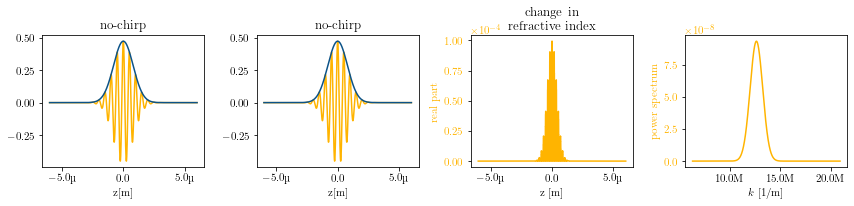

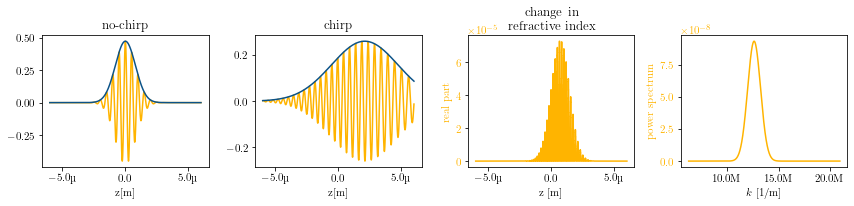

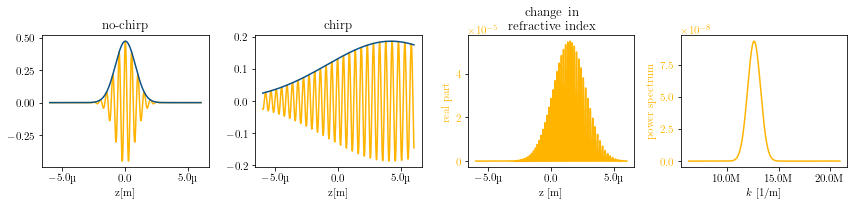

In [16]:
z = np.linspace(-6*c.MICRO, 6*c.MICRO, 2000)
probing_wave = w.GaussianPlanarWave(mean=c.GREEN, std=(5*c.MICRO))
for chirp in np.linspace(0, 0.002*c.NANO, 3):
    dielectric = m.SimpleDielectric(z=z, n0=1.45, name="transfer matrices")
    chirped_wave = w.ChirpedPlanarWave(mean=c.GREEN, std=(5*c.MICRO), skew=chirp)
    chirped_wave.shift(chirp*2000)
    dielectric.record(chirped_wave, probing_wave)
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4,  figsize=(12, 3))
    chirped_wave.plot_amplitude(z, ax=ax1)
    probing_wave.plot_amplitude(z, ax=ax0)
    ax1.set_title("no-chirp" if chirp == 0 else "chirp")
    ax0.set_title("no-chirp")
    dielectric.plot(ax=ax2, change_only=True)
    dielectric.reflect(s_replay).plot(ax3)
    ax2.ticklabel_format(axis='y', useOffset=False, style="sci", scilimits=(0,0))
    plt.tight_layout()
    plt.savefig(figures_dir + "chirp_mixed_{:2.0e}.pdf".format(chirp))
    plt.show()

### Gratings

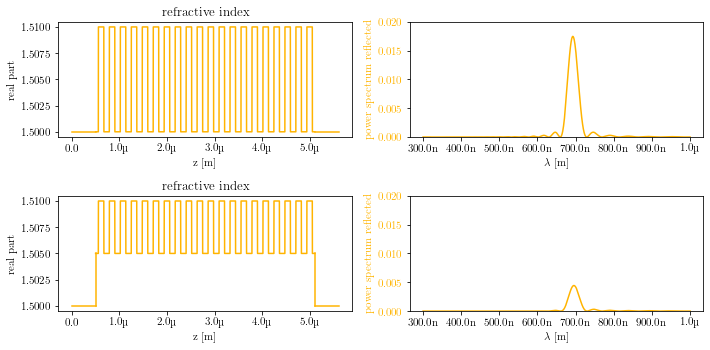

In [17]:
period = 230*c.NANO
N = 20
Z_max = N*period/2
z_layered = np.linspace(-Z_max, Z_max, 2000)

z_clean = np.linspace(-0.5*c.MICRO, 0, 3)
clean = m.SimpleDielectric(z=z_clean, n0=1.5)
clean2 = m.SimpleDielectric(z=z_clean, n0=1.5)

layered = m.LayeredMaterial(z=z_layered, n_layers=N, layer_width=0.5*period, n0=1.5, n1=1.51)
composite = m.CompositeMaterial([clean, layered, clean2])

fig, axes = plt.subplots(2, 2, figsize=(10, 5))
composite.plot(axes[0,0], color="C0")
composite.reflect(s_replay).plot(axes[0,1], label="reflected", wavelength=True)
axes[0,1].set_ylim(0, 0.02)

layered = m.LayeredMaterial(z=z_layered, n_layers=N, layer_width=0.5*period, n0=1.505, n1=1.51)
composite = m.CompositeMaterial([clean, layered, clean2])

composite.plot(axes[1,0], color="C0")
composite.reflect(s_replay).plot(axes[1,1], label="reflected", wavelength=True)
axes[1,1].set_ylim(0, 0.02)

fig.tight_layout() 
plt.savefig(figures_dir + "grating.pdf",transparent=True)
plt.show()